# vision.learner

---

## 计算机视觉Learner

`vision.learner`是定义cnn_learner方法的模块，可以轻松获得适合转移学习的模型。

---

## 迁移学习

转移学习是一种技术，您可以使用在非常大的数据集（通常是计算机视觉中的ImageNet）上训练的模型，然后将其调整到您自己的数据集。 我们的想法是，它已经学会识别所有这些数据的许多功能，并且您将从这些知识中受益，特别是如果您的数据集很小，与从随机初始化模型开始相比。 在本文中已经证明，转移学习几乎总能带来更好的结果。

在实践中，您需要更改模型的最后部分以适应您自己的类数。 大多数卷积模型以几个线性层结束（一个部分将调用头部）。 最后一个卷积层将分析通过模型的图像中的特征，头部的工作是转换每个类的预测中的那些。 在转移学习中，我们将保留所有卷积层（称为模型的主体或主干），其权重在ImageNet上预先训练，但将定义一个随机初始化的新头。

然后我们将分两个阶段训练我们获得的模型：首先我们冻结体重并且仅训练头部（将这些分析的特征转换为我们自己的数据的预测），然后我们解冻骨干层（如果必要的话逐渐） 并微调整个模型（可能使用差异学习率）。

cnn_learner工厂方法可帮助您使用适合您数据的自定义头自动从给定体系结构中获取预训练模型。

**cnn_learner**

`cnn_learner(data:DataBunch, base_arch:Callable, cut:Union[int, Callable]=None, pretrained:bool=True, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, custom_head:Optional[Module]=None, split_on:Union[Callable, Collection[ModuleList], NoneType]=None, bn_final:bool=False, init='kaiming_normal_', concat_pool:bool=True, **kwargs:Any) → Learner`

建立卷积风格的Learner。

此方法从数据对象和模型中创建一个`Learner`对象，并使用arch中给出的主干。 具体来说，默认情况下（或者在cut中定义，见下文），它将在最后一个卷积层中剪切由arch定义的模型（如果预训练为False则随机初始化）（并且添加：
* 一个AdaptiveConcatPool2d层，
* 全连接层，
* [nn.BatchNorm1d，nn.Dropout，nn.Linear，nn.ReLU]图层的块。

这些块由lin_ftrs和ps参数定义。 具体来说，第一个块将具有从主干拱推断的多个输入，并且最后一个将具有等于data.c的数量的输出（其包含数据的类的数量）并且中间块具有多个 由lin_frts确定的输入/输出（当然，块的输入数量等于前一个块的输出数量）。 默认情况下，中间隐藏大小为512（这使得两个块model_activation  - > 512  - > n_classes）。 如果你传递一个浮点数，那么最终的dropout图层将具有值ps，剩下的将是ps / 2。 如果您传递一个列表，那么这些值将直接用于丢失概率。

请注意，最后一个块没有nn.ReLU激活，允许您使用所需的任何最终激活（通常包含在pytorch中的loss函数中）。 此外，如果您选择pretrained = True（因此只有头部将训练，如果您称之为适合），骨干将被冻结，以便您可以立即开始如上所述的训练的第一阶段。

或者，您可以定义自己的custom_head以置于主干之上。 如果你想指定在哪里拆分arch你应该在参数cut中这可以是特定图层的索引（结果将不包括该图层）或者一个函数，当传递模型时，将返回你希望的骨干。

然后通过堆叠骨架和头部（定制或如我们所见定义）获得的最终模型分组，以逐渐解冻或差异学习率。 您可以使用可选参数split_on指定如何在组中拆分主干（应该是在给定主干时返回这些组的函数）。

kwargs将被传递给Learner，因此你可以将Learner接受的任何东西放到这里（metrics，loss_func，opt_func ......）

In [3]:
from fastai.vision import *

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)

In [9]:
learner = cnn_learner(data, models.resnet18, metrics=[accuracy])
learner.fit_one_cycle(1,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.115900,0.067808,0.977920,01:13


In [6]:
learner.save('one_epoch')

**unet_learner**

`unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True, norm_type:Optional[NormType]='NormType', split_on:Union[Callable, Collection[ModuleList], NoneType]=None, blur:bool=False, self_attention:bool=False, y_range:OptRange=None, last_cross:bool=True, bottle:bool=False, cut:Union[int, Callable]=None, **learn_kwargs:Any) → Learner`

从数据和arch构建Unet Learner。

这次模型将是一个DynamicUnet，其中包含一个基于arch（可能是预训练）的编码器，该编码器根据split_on进行切割。 将blur_final，norm_type，blur，self_attention，y_range，last_cross和bottle传递给unet构造函数，将kwargs传递给Learner的初始化。

警告：使用此函数创建的模型不能与pytorch`nn.DataParallel`一起使用，您必须使用分布式训练！

## 得到预测
实际训练模型后，您可能希望在单个图像上使用它。 这是通过使用以下方法完成的。

**predict**

`predict(item:ItemBase, return_x:bool=False, batch_first:bool=True, with_dropout:bool=False, **kwargs)`

返回项目的预测类别，标签和概率。

In [7]:
img = learner.data.train_ds[0][0]
learner.predict(img)

(Category 3, tensor(0), tensor([0.9891, 0.0109]))

In [8]:
img

这里我们图像的预测类是'3'，它对应于0的标签。模型为每个类找到的概率分别为99.65％和0.35％，因此它的置信度非常高。

请注意，如果要加载训练有素的模型并使用之前的功能在推理模式下使用它，则应导出Learner。

In [10]:
learner.export()

然后你可以用一个具有相同内部状态的空数据对象加载它，如下所示：

In [11]:
learn = load_learner(path)

## 自定义您的模型

您可以通过将cnn_learner添加到字典model_meta来为您自己的模型的默认剪切和split_on函数自定义cnn_learner。 键应该是您的模型，值应该是具有cut cut和split_on的字典（请参阅示例的源代码）。 构造函数将根据cut调用create_body和create_head; 你也可以自己调用，这对测试特别有用。

**create_body**

`create_body(arch:Callable, pretrained:bool=True, cut:Union[int, Callable, NoneType]=None)`

在cut（int）处切断通常预先训练的模型的主体，或者切割（模型）（函数）指定的模型。

**create_head**

`create_head(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, concat_pool:bool=True, bn_final:bool=False)`

模型头具有nf功能，通过lin_ftrs运行，以nc类结束。 ps是辍学的概率，如上面cnn_learner中所述。

## class ClassificationInterpretation
`ClassificationInterpretation(learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=<DatasetType.Valid: 2>) :: Interpretation`

分类模型的解释方法。

这提供了混淆矩阵和最不正确图像的可视化。 传递您的数据，计算的预测值，实际y和您的损失，然后使用以下方法查看模型解释结果。 例如：

In [12]:
learn = cnn_learner(data, models.resnet18)
learn.fit(1)
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

**以下工厂方法提供了一种更方便的方法来创建此类的实例：**

**from_learner**

`from_learner(learn:Learner, ds_type:DatasetType=<DatasetType.Valid: 2>, tta=False)`

创建ClassificationInterpretation的实例。 tta表示我们是否要使用Test Time Augmentation。

您也可以使用快捷方式learn.interpret（）来执行相同操作。

**interpret**

`interpret(learn:Learner, ds_type:DatasetType=<DatasetType.Valid: 2>, tta=False)`

使用tta在ds_type上从学习者创建ClassificationInterpretation对象。

请注意，此快捷方式是Learner对象/类方法，可以将其命名为：learn.interpret（）。

**plot_top_losses**

`plot_top_losses(k, largest=True, figsize=(12, 12), heatmap:bool=None, heatmap_thresh:int=16, return_fig:bool=None) → Optional[Figure]`

在top_losses中显示图像以及它们的预测，实际，损失和实际课程的概率。

k个项目排列为正方形，因此如果k是正方形数字（4,9,16等），它看起来最好。 每个图像的标题显示：预测，实际，损失，实际类别的概率。 当热图为True（默认情况下为True）时，Grad-CAM热图（http://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf）会叠加在每个图像上。 plot_top_losses应与单标签数据集一起使用。 有关能够处理多标记数据集的版本，请参阅下面的plot_multi_top_losses。

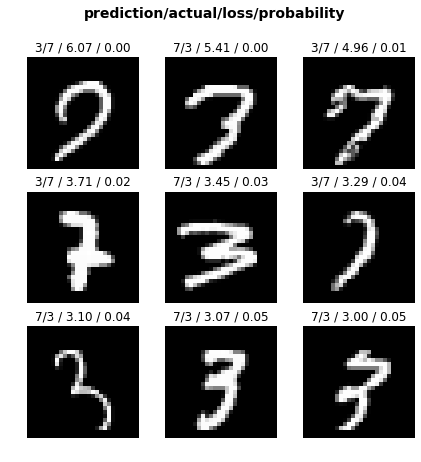

In [17]:
interp.plot_top_losses(9, figsize=(7,7))

**plot_multi_top_losses**

`plot_multi_top_losses(samples:int=3, figsize:Tuple[int, int]=(8, 8), save_misclassified:bool=False)`

在top_losses中显示图像以及它们在多标记数据集中的预测类别的预测，实际，损失和概率。

与plot_top_losses（）类似，但针对多标签数据集。 它绘制了按各自损失排序的错误分类样本。 由于单个样本可以有多个标签，因此它们可以轻松地在网格图中重叠。 所以它每行只绘制一个样本。
请注意，您可以传递save_misclassified = True（默认情况下为False）。 在这种情况下，该方法将返回包含错误分类图像的列表，您可以使用该列表调试模型和/或调整其超参数。